In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Goal: Compute Real GDP

In the US, the Bureau of Economic Analysis already provides an estimate of real GDP. We'll calculate something similar:

$$
real\_GDP = \frac{nominal\_GDP}{price\_index}
$$

* U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items in U.S. City Average [CPIAUCSL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPIAUCSL, October 31, 2020.
* U.S. Bureau of Economic Analysis, Gross Domestic Product [GDP], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/GDP, October 31, 2020.

In [18]:
gdp_bad = pd.read_csv("data/GDP.csv.gz")
cpi_bad = pd.read_csv("data/CPIAUCSL.csv.gz")

Our formula says `real_gdp = gdp / cpi`, so...

In [21]:
%xmode plain

gdp_bad / cpi_bad

Exception reporting mode: Plain


TypeError: unsupported operand type(s) for /: 'str' and 'str'

What happened?

In [24]:
gdp_bad

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742
...,...,...
290,2019-07-01,21540.325
291,2019-10-01,21747.394
292,2020-01-01,21561.139
293,2020-04-01,19520.114


In [25]:
# use .squeeze to convert a 1 column df to a Series
gdp = pd.read_csv('data/GDP.csv.gz', index_col='DATE',
                  parse_dates=['DATE'])["GDP"]
gdp.head()

DATE
1947-01-01    243.164
1947-04-01    245.968
1947-07-01    249.585
1947-10-01    259.745
1948-01-01    265.742
Name: GDP, dtype: float64

In [26]:
cpi = pd.read_csv('data/CPIAUCSL.csv.gz', index_col='DATE',
                  parse_dates=['DATE'])["CPIAUCSL"]
cpi.head()

DATE
1947-01-01    21.48
1947-02-01    21.62
1947-03-01    22.00
1947-04-01    22.00
1947-05-01    21.95
Name: CPIAUCSL, dtype: float64

In [27]:
rgdp = gdp / cpi
rgdp


DATE
1947-01-01    11.320484
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    11.180364
1947-05-01          NaN
                ...    
2020-05-01          NaN
2020-06-01          NaN
2020-07-01    81.777171
2020-08-01          NaN
2020-09-01          NaN
Length: 885, dtype: float64

**What happened?**

In pandas, any time you do an operation involving multiple pandas objects (dataframes, series), pandas will *align* the inputs. Alignment is a two-step process:

1. Take the union of the labels
2. Reindex the inputs to the union of the labels

In [29]:
# manual alignment, just for demonstration:

all_dates = gdp.index.union(cpi.index)
all_dates

DatetimeIndex(['1947-01-01', '1947-02-01', '1947-03-01', '1947-04-01',
               '1947-05-01', '1947-06-01', '1947-07-01', '1947-08-01',
               '1947-09-01', '1947-10-01',
               ...
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', name='DATE', length=885, freq='MS')

In [30]:
gdp2 = gdp.reindex(all_dates)
gdp2

DATE
1947-01-01      243.164
1947-02-01          NaN
1947-03-01          NaN
1947-04-01      245.968
1947-05-01          NaN
                ...    
2020-05-01          NaN
2020-06-01          NaN
2020-07-01    21157.635
2020-08-01          NaN
2020-09-01          NaN
Freq: MS, Name: GDP, Length: 885, dtype: float64

In [31]:
cpi2 = cpi.reindex(all_dates)
cpi2

DATE
1947-01-01     21.480
1947-02-01     21.620
1947-03-01     22.000
1947-04-01     22.000
1947-05-01     21.950
               ...   
2020-05-01    255.768
2020-06-01    257.214
2020-07-01    258.723
2020-08-01    259.681
2020-09-01    260.209
Freq: MS, Name: CPIAUCSL, Length: 885, dtype: float64

In [33]:
rgdp2 = gdp2 / cpi2
rgdp2

DATE
1947-01-01    11.320484
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    11.180364
1947-05-01          NaN
                ...    
2020-05-01          NaN
2020-06-01          NaN
2020-07-01    81.777171
2020-08-01          NaN
2020-09-01          NaN
Freq: MS, Length: 885, dtype: float64

So when we wrote

```python
rgdp = gdp / cpi
```

pandas performs

```python
all_dates = gdp.index.union(cpi.index)
rgdp = gdp.reindex(all_dates) / cpi.reindex(all_dates)
```

## Missing Data

## Exercise

In [43]:
def fetch(code):
    url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id={code}&scale=left&cosd=2000-12-01&coed=2020-08-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2020-11-01&revision_date=2020-11-01&nd=2000-12-01".format(code=code)
    return pd.read_csv(url, index_col="DATE", parse_dates=["DATE"])[code]

In [45]:
series = ['JTSJOL', 'JTSQUL', 'JTSHIL', 'JTSLDL']
names = ['openings', 'quits', 'hires', 'layoffs']

colors = {'quits': '#52b5ea', 'layoffs': '#d32c2c',
          'hires': '#2531db', 'openings': '#fffb49'}

area_colors = [colors['quits'], colors['layoffs']]
line_colors = [colors['hires'], colors['openings']]

In [46]:
dfs = [fetch(code) for code in series]
dfs

[DATE
 2000-12-01    4868
 2001-01-01    5362
 2001-02-01    5008
 2001-03-01    4698
 2001-04-01    4752
               ... 
 2020-04-01    4996
 2020-05-01    5371
 2020-06-01    6001
 2020-07-01    6697
 2020-08-01    6493
 Name: JTSJOL, Length: 237, dtype: int64,
 DATE
 2000-12-01    2868
 2001-01-01    3261
 2001-02-01    3040
 2001-03-01    3041
 2001-04-01    3172
               ... 
 2020-04-01    1877
 2020-05-01    2067
 2020-06-01    2605
 2020-07-01    2932
 2020-08-01    2793
 Name: JTSQUL, Length: 237, dtype: int64,
 DATE
 2000-12-01    5426
 2001-01-01    5722
 2001-02-01    5303
 2001-03-01    5528
 2001-04-01    5204
               ... 
 2020-04-01    4047
 2020-05-01    7199
 2020-06-01    6970
 2020-07-01    5903
 2020-08-01    5919
 Name: JTSHIL, Length: 237, dtype: int64,
 DATE
 2000-12-01    2035
 2001-01-01    2220
 2001-02-01    1838
 2001-03-01    2126
 2001-04-01    1880
               ... 
 2020-04-01    7708
 2020-05-01    1903
 2020-06-01    1995
 2020-07-0

<AxesSubplot:xlabel='DATE'>

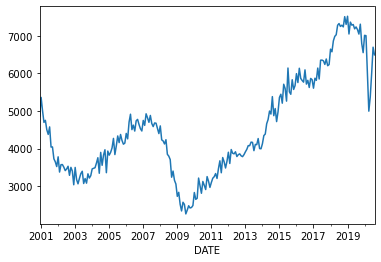

In [48]:
dfs[0].plot()